# K-Nearest Neighbours (KNN) for Fraud Detection

---

* KNN, Supervised learning algorithm:
  - assumption: similar inputs have similar outputs
  - high similarity implies same class label

* Algorithm:
  - train set
  - distance function to calculate similarity : Euclidean , Mahalanobis
  - Hyperparameter, K
  - Find k-closest points to new point 
  - Decision strategy : Mode or weighted distances?
  - Assign new point to fraud or no fraud based on strategy

* Choosing K:
  - can use cross-validation, elbow method?

* Improving KNN
  - change the metric distance
  - dimensionality reduction
  - rescaling and normalization
  - modified approach

* Visualization of the likelihood a new test point belongs to a class.



---

# Import libraries

---

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt 

#sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV
from sklearn.neighbors import DistanceMetric


# import custom functions

from custom_functions import get_data_summary, our_metrics, eval_metrics, evaluate_model


import warnings
warnings.filterwarnings('ignore')

---

# Load necessary processed data

---

* Unscaled Data (test_size = 0.25) :
  - X_train.csv
  - X_test.csv
  - y_train.csv
  - y_test.csv

* Scaled Data - minmax scaler (normalization) :
  - X_train_std.csv
  - X_test_std.csv

* Scaled Data - standard scaler (standardization) :
  - X_train_minmax.csv
  - X_test_minmax.csv

* minmax scaled with x_train_minmax and y_train split using test_size = 0.7 :
  - X_train_minmax_small.csv (train?)
  - y_train_minmax_small.csv (train)
  - X_train_minmax_large.csv (still train? since scaled)
  - y_train_minmax_large.csv (test)

* standard scaler with x_train_std and y_train split using test_size = 0.7 :
  - X_train_std_small.csv (train?)
  - y_train_std_small.csv (train)
  - X_train_std_large.csv (now test)
  - y_train_std_large.csv (test)



In [2]:

# loading the data files


# unscaled Data (test_size = 0.25) :

X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

# scaled Data - minmax scaler

X_train_std = pd.read_csv("data/X_train_std.csv")
X_test_std  = pd.read_csv("data/X_test_std.csv")

# scaled Data - standard scaler

X_train_minmax  = pd.read_csv("data/X_train_minmax.csv")
X_test_minmax  = pd.read_csv("data/X_test_minmax.csv")

# minmax scaled with x_train_minmax and y_train split using test_size = 0.7

X_train_minmax_small  = pd.read_csv("data/X_train_minmax_small.csv")
X_train_minmax_large  = pd.read_csv("data/X_train_minmax_large.csv")

# standard scaler with x_train_std and y_train split using test_size = 0.7

X_train_std_small  = pd.read_csv("data/X_train_std_small.csv")
X_train_std_large  = pd.read_csv("data/X_train_std_large.csv")

y_train_small  = pd.read_csv("data/y_train_small.csv")
y_train_large  = pd.read_csv("data/y_train_large.csv")





In [3]:
# checking the shape data files

print('____'*12)

print(f" X_train : {X_train.shape}")
print(f" X_test :{X_test.shape}")

print('____'*12)

print(f" y_train : {y_train.shape}")
print(f" y_test : {y_test.shape}")

print('____'*12)

print(f" X_train_std : {X_train_std.shape}")
print(f" X_test_std : {X_test_std.shape}")

print('____'*12)

print(f" X_train_minmax : {X_train_minmax.shape}")
print(f" X_test_minmax : {X_test_minmax.shape}")

print('____'*12)

print(f" X_train_minmax_small : {X_train_minmax_small.shape}")
print(f" X_train_minmax_large : {X_train_minmax_large.shape}")

print('____'*12)

print(f" X_train_std_small : {X_train_std_small.shape}")
print(f" X_train_std_large : {X_train_std_large.shape}")

print('____'*12)

print(f" y_train_small : {y_train_small.shape}")
print(f" y_train_large : {y_train_large.shape}")



________________________________________________
 X_train : (3357517, 47)
 X_test :(1119173, 47)
________________________________________________
 y_train : (3357517, 1)
 y_test : (1119173, 1)
________________________________________________
 X_train_std : (3357517, 47)
 X_test_std : (1119173, 47)
________________________________________________
 X_train_minmax : (3357517, 47)
 X_test_minmax : (1119173, 47)
________________________________________________
 X_train_minmax_small : (1007255, 47)
 X_train_minmax_large : (2350262, 47)
________________________________________________
 X_train_std_small : (1007255, 47)
 X_train_std_large : (2350262, 47)
________________________________________________
 y_train_small : (1007255, 1)
 y_train_large : (2350262, 1)


---

# Global Variables

---

In [4]:
# global variables

# for reproducibility sake
RSEED = 42

# test values for the n_neighbors parameter for unscaled X_train
params_0 = {
            'n_neighbors' : [50, 100, 500, len(X_train//16),
                len(X_train//8), len(X_train//4),  len(X_train//2)],   
        }

Threshold = 0.5



---

# Distance measure

---

metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(train_features))




---

# K-neighbours classifier 

---

* initialize model
* cross validation to find optima K : random search , grid search
* fit model 
* parameters used :
<br> <br/>


```python

cv_params = [
    {'n_neighbors': np.arange(1, 51), 'metric': ['euclidean', 'minkowski']},
    {'n_neighbors': np.arange(1, 51), 'metric': ['mahalanobis', 'seuclidean'],
     'metric_params': [{'V': np.cov(train_input_data)}]}
]

```

---

Dimensionality reduction :

* how to solve th curse of dimensionality problem
* Using principal component analysis (PCA)
    - if data has multi-colinearity between the features or variables
    - if the input data is high dimensional (lots feature variables)




In [5]:
n_samples = 4000

n_x_train = X_train[:n_samples]
n_y_train = y_train[:n_samples]
n_x_test = X_test[:n_samples]
n_y_test = y_test[:n_samples]

print(f" n samples from x_train : {n_x_train.shape}")
print(f" n samples from y_train : {n_y_train.shape}")

print("_____"*25)

print(f" n samples from x_test : {n_x_test.shape}")
print(f"  n samples from y_test : {n_y_test.shape}")


 n samples from x_train : (4000, 47)
 n samples from y_train : (4000, 1)
_____________________________________________________________________________________________________________________________
 n samples from x_test : (4000, 47)
  n samples from y_test : (4000, 1)


In [7]:
## scorer names
# import sklearn.metrics as sm
# sm.get_scorer_names()



## results of grid search run previously

_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________
best K grid search: 60
best metric grid search: mahalanobis
_____________________________________________________________________________________________________________________________
optimal parameters, score, algorithm

        
_____________________________________________________________________________________________________________________________
best score gridcv : 0.5740317387792053
_____________________________________________________________________________________________________________________________
best params gridcv : {'algorithm': 'auto', 'metric': 'mahalanobis', 'metric_params': {'VI': array([[ 162.91281221,  134.91084644,  110.33487512, ...,   99.82215541,
         376.41258094,   19.60800185],
       [ 134.91084644,  243.40304117,   95.24653099, ...,  137.64743293,
         477.60430157,  115.94993062],
       [ 110.33487512,   95.24653099,   78.61170213, ...,   71.97548566,
         259.30018501,   14.363321  ],
       ...,
       [  99.82215541,  137.64743293,   71.97548566, ...,   86.23751156,
         299.49213691,   52.31429232],
       [ 376.41258094,  477.60430157,  259.30018501, ...,  299.49213691,
        1078.95559667,  171.19426457],
       [  19.60800185,  115.94993062,   14.363321  , ...,   52.31429232,
         171.19426457,   78.85661425]])}, 'n_neighbors': 60, 'weights': 'uniform'}
_____________________________________________________________________________________________________________________________
best estimator gridcv : KNeighborsClassifier(metric='mahalanobis',
                     metric_params={'VI': array([[ 162.91281221,  134.91084644,  110.33487512, ...,   99.82215541,
         376.41258094,   19.60800185],
       [ 134.91084644,  243.40304117,   95.24653099, ...,  137.64743293,
         477.60430157,  115.94993062],
       [ 110.33487512,   95.24653099,   78.61170213, ...,   71.97548566,
         259.30018501,   14.363321  ],
       ...,
       [  99.82215541,  137.64743293,   71.97548566, ...,   86.23751156,
         299.49213691,   52.31429232],
       [ 376.41258094,  477.60430157,  259.30018501, ...,  299.49213691,
        1078.95559667,  171.19426457],
       [  19.60800185,  115.94993062,   14.363321  , ...,   52.31429232,
         171.19426457,   78.85661425]])},
                     n_neighbors=60)
___________________________________________




# Train test split 



In [6]:
# checking shape 

print('____'*12)

print(f" X_test : {X_test.shape}")

print('____'*12)

print(f" y_train: {y_train.shape}")
print(f" y_test : {y_test.shape}")

print('____'*12)

print(f" X_train_std : {X_train_std.shape}")
print(f" X_test_std : {X_test_std.shape}")






________________________________________________
 X_test : (1119173, 47)
________________________________________________
 y_train: (3357517, 1)
 y_test : (1119173, 1)
________________________________________________
 X_train_std : (3357517, 47)
 X_test_std : (1119173, 47)


In [7]:
# train_test split on
# - X_train_tree_small,  y_train_tree_small


X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train_std, y_train, test_size=0.997, random_state=RSEED, stratify=y_train)



print(f" y_train_knn: {y_train_knn.shape}")
print(f" y_test_knn : {y_test_knn.shape}")

print('____'*12)

print(f" X_train_knn : {X_train_knn.shape}")
print(f" X_test_knn : {X_test_knn.shape}")






 y_train_knn: (10072, 1)
 y_test_knn : (3347445, 1)
________________________________________________
 X_train_knn : (10072, 47)
 X_test_knn : (3347445, 47)


In [8]:
# cross validation : random search

cv_params_1 = [
    {'n_neighbors': np.arange(15, 61), 'metric': ['euclidean', 'manhattan', 'cosine']},
    # {'n_neighbors': np.arange(1, 51), 'metric': ['mahalanobis', 'seuclidean'],
    # 'metric_params': [{'V': np.cov(n10k_x_train)}]},
    {'n_neighbors': np.arange(15, 61), 
    'metric': ['mahalanobis'],
    'metric_params': [{'VI': np.cov(X_train_knn)}],
    'algorithm' : ['auto', 'brute', 'kd_tree', 'ball_tree'],
    'weights': ['uniform', 'distance']
    }
]



# scoring = ['fbeta_score', 'f1_score', 'roc_auc_score', 'balanced_accuracy_score']
# scoring = ['roc_auc', 'f1_weighted', 'balanced_accuracy']

knn_cv_test_1 = KNeighborsClassifier()

knn_cv_rs_1 = RandomizedSearchCV(knn_cv_test_1, cv_params_1, 
                                scoring = 'roc_auc', 
                                cv= 5, verbose= 0, n_iter= 20, n_jobs = -1, 
                                return_train_score= True, random_state= RSEED ) #, refit= False)


print("_____"*25)
print("_____"*25)

# fit model with best param
knn_cv_rs_1.fit(X_train_knn, y_train_knn)

print("_____"*25)
print("_____"*25)


# get optimal K hyperparameter and metric

best_k_1 = knn_cv_rs_1.best_params_.get('n_neighbors')
best_metric_1 = knn_cv_rs_1.best_params_.get('metric')

print("_____"*25)

print(f"best K random search: {best_k_1}")
print(f"best metric random search: {best_metric_1}")

print("_____"*25)






_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


/Users/graceeze/Documents/data_practitioner_repos/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/graceeze/Documents/data_practitioner_repos/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/graceeze/Documents/data_practitioner_repos/fraud_detection_electricity_company/.venv/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________
best K random search: 47
best metric random search: cosine
_____________________________________________________________________________________________________________________________


In [10]:
# params


knn_cv_rsp1 = pd.DataFrame(knn_cv_rs_1.cv_results_['params']).drop('metric_params', axis=1)
knn_cv_rsp1.head()


,weights,n_neighbors,metric,algorithm
0,distance,32,mahalanobis,auto
1,uniform,37,mahalanobis,brute
2,distance,53,mahalanobis,ball_tree
3,NaN,41,manhattan,NaN
4,uniform,34,mahalanobis,ball_tree


In [11]:
# all results the KNN cv

knn_cv_rspo = pd.DataFrame(knn_cv_rs_1.cv_results_)[['mean_train_score', 'mean_test_score',  'rank_test_score']]


knn_cv_results_1 = pd.concat([knn_cv_rsp1, knn_cv_rspo], axis=1)

knn_cv_results_1 


,weights,n_neighbors,metric,algorithm,mean_train_score,mean_test_score,rank_test_score
0,distance,32,mahalanobis,auto,1.000000,0.523752,10
1,uniform,37,mahalanobis,brute,0.695677,0.532833,9
2,distance,53,mahalanobis,ball_tree,NaN,NaN,12
3,NaN,41,manhattan,NaN,0.734547,0.616728,4
4,uniform,34,mahalanobis,ball_tree,NaN,NaN,12
5,NaN,45,manhattan,NaN,0.729190,0.620729,3
6,uniform,58,mahalanobis,brute,0.676397,0.550461,6
7,uniform,16,mahalanobis,auto,0.759151,0.510615,11
8,distance,43,mahalanobis,ball_tree,NaN,NaN,12
9,uniform,58,mahalanobis,ball_tree,NaN,NaN,12


In [9]:

# print out best parameters, scoresa and estimator (algorithm)


print(f'''optimal parameters, score, algorithm

        ''')

print("_____"*25)


# knn_cv_grid_1.get_params()
# knn_cv_grid_1.cv_results_

print(f"best score randomcv : {knn_cv_rs_1.best_score_}")
print("_____"*25)

print(f"best params randomcv : {knn_cv_rs_1.best_params_}")
print("_____"*25)

print(f"best estimator randomcv : {knn_cv_rs_1.best_estimator_}")
print("_____"*25)





optimal parameters, score, algorithm

        
_____________________________________________________________________________________________________________________________
best score randomcv : 0.6274781018844139
_____________________________________________________________________________________________________________________________
best params randomcv : {'n_neighbors': 47, 'metric': 'cosine'}
_____________________________________________________________________________________________________________________________
best estimator randomcv : KNeighborsClassifier(metric='cosine', n_neighbors=47)
_____________________________________________________________________________________________________________________________


In [13]:
##
# draft fit on X_train

best_k_rs = 47

knn_rs_cos = KNeighborsClassifier(metric='cosine', n_neighbors=best_k_rs)
knn_rs_cos.fit(X_train_knn, y_train_knn)
knn_rs_cos.score(X_test_knn, y_test_knn)





0.9211225277786491

In [14]:
# params

#knn_pca.get_params().keys()

knn_rs_cos.get_params()


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 47,
 'p': 2,
 'weights': 'uniform'}

# Evaluation and Results


In [17]:
# predicted probabilities knn random search on standardized large X test

x_test_knnrs_probs = knn_rs_cos.predict_proba(X_test_knn)
x_test_knnrs_probs




array([[0.85106383, 0.14893617],
       [0.91489362, 0.08510638],
       [0.87234043, 0.12765957],
       ...,
       [0.85106383, 0.14893617],
       [0.95744681, 0.04255319],
       [0.9787234 , 0.0212766 ]])

In [21]:
# predicted probabilities knn random search on originally unscaled X_test

x_train_knnrs_probs = knn_rs_cos.predict_proba(X_train_knn)
x_train_knnrs_probs 




array([[0.95744681, 0.04255319],
       [0.9787234 , 0.0212766 ],
       [0.82978723, 0.17021277],
       ...,
       [0.93617021, 0.06382979],
       [0.89361702, 0.10638298],
       [0.95744681, 0.04255319]])

In [23]:
# predictions

y_pred_knnrs_train = knn_rs_cos.predict(X_train_knn)
y_pred_knnrs_test = knn_rs_cos.predict(X_test_knn)




In [29]:

# cleaned data used in modelling notebook

df_processed = pd.read_csv('data/df_processed_dmy.csv')


## Defining baseline model that predicts no one commits fraud
def baseline_model(df):
    y_pred = [0 for x in df.index]
    return y_pred

# Compute predictions with baseline model  1 for test set

y_pred_baseline_1 = baseline_model(X_test)


# Defining baseline model that predicts no one commits fraud for 
#  index change with respect to consuption per month <= 15% is fraud


quantile_idx = df_processed[['index_change_month']].quantile(q=0.15)[0]
quantile_idx

def baseline_model_idx(df, quantile_idx):
    y_pred = [1 if x <= quantile_idx else 0 for x in df['index_change_month']]
    return y_pred

# Compute predictions with baseline modelv2 for test set
y_pred_baseline_2 = baseline_model_idx(X_test, quantile_idx)




In [30]:

# our metrics : evaluation and results
# - Train
# - Test
# - Baseline 1
# - Baseline 2

print(f'Train ROC AUC Score: {roc_auc_score(y_train_knn, y_pred_knnrs_train)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test_knn, y_pred_knnrs_test)}')
print(f'Baseline 1 ROC AUC Score: {roc_auc_score(y_test,  y_pred_baseline_1)}')
print(f'Baseline 2 ROC AUC Score: {roc_auc_score(y_test, y_pred_baseline_2)}')





Train ROC AUC Score: 0.5
Test ROC AUC  Score: 0.5
Baseline 1 ROC AUC Score: 0.5
Baseline 2 ROC AUC Score: 0.49537146567264756


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9212
_____________________
F1-score: 0.0
_____________________
Fbeta_score with beta=1.5: 0.0
_____________________
Fbeta_score with beta=2: 0.0
_____________________
Fbeta_score with beta=3: 0.0
_____________________
Recall 0.0
_____________________
Specificity 1.0
Train metrics:  
  None


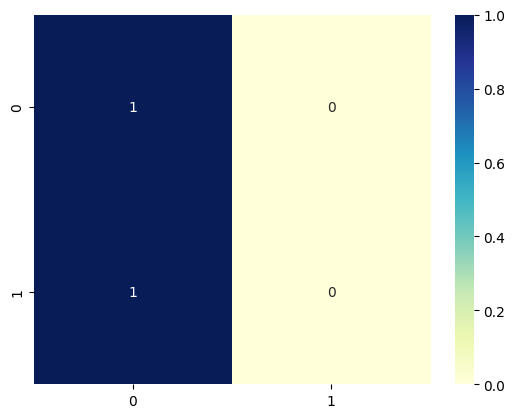

In [37]:

# our metrics : evaluation and results
# - Train

print(f'Train metrics:  \n  {our_metrics(y_train_knn, y_pred_knnrs_train)}')




Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9211
_____________________
F1-score: 0.0
_____________________
Fbeta_score with beta=1.5: 0.0
_____________________
Fbeta_score with beta=2: 0.0
_____________________
Fbeta_score with beta=3: 0.0
_____________________
Recall 0.0
_____________________
Specificity 1.0
Test metrics:  
  None


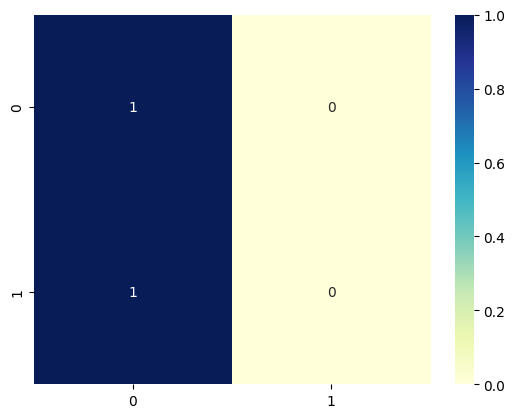

In [38]:

# - Test

print(f'Test metrics:  \n  {our_metrics(y_test_knn, y_pred_knnrs_test)}')



Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.9211
_____________________
F1-score: 0.0
_____________________
Fbeta_score with beta=1.5: 0.0
_____________________
Fbeta_score with beta=2: 0.0
_____________________
Fbeta_score with beta=3: 0.0
_____________________
Recall 0.0
_____________________
Specificity 1.0
Baseline 1 Metrics:  
 None


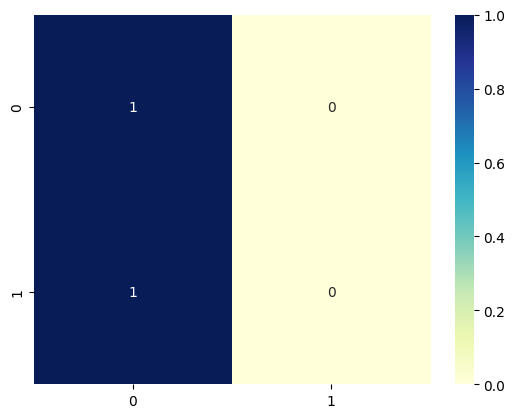

In [39]:

# - Baseline 1
print(f'Baseline 1 Metrics:  \n {our_metrics(y_test, y_pred_baseline_1)}')




Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.7922
_____________________
F1-score: 0.0979
_____________________
Fbeta_score with beta=1.5: 0.1114
_____________________
Fbeta_score with beta=2: 0.1207
_____________________
Fbeta_score with beta=3: 0.1309
_____________________
Recall 0.1429
_____________________
Specificity 0.8478
Baseline 2 Metrics: 
 None


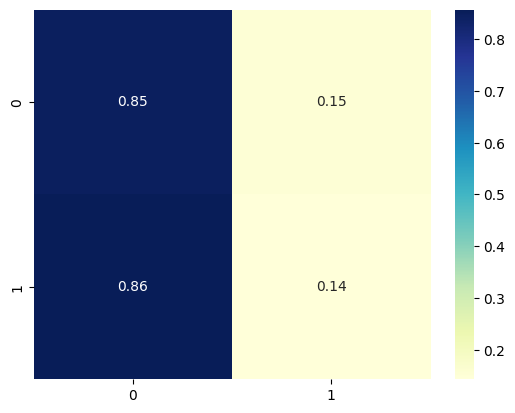

In [40]:

# - Baseline 2

print(f'Baseline 2 Metrics: \n {our_metrics(y_test, y_pred_baseline_2)}')






# Error Analysis




In [62]:
# predict probabilities on labels as well to make them comparable 

y_train_pred_probs = knn_rs_cos.predict_proba(y_train_knn)[:, 1]
y_test_pred_probs = knn_rs_cos.predict_proba(y_test_knn)[:, 1]



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- target
Feature names seen at fit time, yet now missing:
- 0
- 1
- 10
- 11
- 12
- ...


# PCA 



In [ ]:

print('____'*12)

print(f" X_test : {X_test.shape}")

print('____'*12)

print(f" y_train: {y_train.shape}")
print(f" y_test : {y_test.shape}")

print('____'*12)

print(f" X_train_std : {X_train_std.shape}")
print(f" X_test_std : {X_test_std.shape}")

print('____'*12)

print(f" y_train: {y_train_knn.shape}")
print(f" y_test : {y_test_knn.shape}")

print('____'*12)

print(f" X_train_std : {X_train_knn.shape}")
print(f" X_test_std : {X_test_knn.shape}")



In [ ]:
# PCA

from sklearn.decomposition import PCA

#pca=PCA(0.95)
pca=PCA()

x_train_pca = pca.fit_transform(reduced_x_train)
x_train_pca



array([[-4.51437429e+02, -4.94041323e+01,  7.31304055e+00, ...,
        -1.16736683e-12,  3.09185562e-12, -5.38327126e-12],
       [-4.33179996e+02,  2.74821652e+01, -5.13209279e+00, ...,
        -1.68354545e-13,  7.06156711e-14,  3.20046960e-13],
       [-4.23437857e+02, -5.09227302e+01, -5.95155427e+00, ...,
         2.48635754e-12,  2.44250077e-12, -2.46986022e-11],
       ...,
       [-4.46309406e+02, -1.70262820e+01, -3.11366401e+00, ...,
         1.28321108e-13,  5.04281891e-14,  1.06400385e-13],
       [-4.91768664e+02, -2.80826350e+01,  5.69717548e+00, ...,
        -6.13856871e-14,  9.14026792e-16,  3.63711631e-13],
       [-3.72934406e+02, -1.92573133e+01,  7.70649257e+00, ...,
        -7.35484972e-14,  1.48170097e-13,  2.40193043e-12]])

In [ ]:
# shape

x_size = x_train_pca.shape

# get number of components

ncomp = pca.n_components_

print(f"x train pca size : {x_size}")
print(f"no of components : {ncomp}")




x train pca size : (1850, 47)
no of components : 47


In [ ]:
x_test_pca = pca.transform(reduced_x_test)
x_test_pca

array([[-3.80932234e+02,  3.39151032e+00,  3.22494484e+00, ...,
         7.76199223e-18,  1.26969099e-18,  4.93806846e-17],
       [-3.84306160e+02,  1.26541260e+01,  1.03150118e+01, ...,
         6.55675468e-19,  6.14876422e-19,  1.60402987e-16],
       [-3.63933185e+02, -7.33218167e+00,  9.05738002e+00, ...,
        -4.81498117e-17, -1.32142056e-17,  2.15914138e-16],
       ...,
       [-3.94430374e+02,  2.31723516e+01, -2.58900406e+00, ...,
         9.12099608e-18,  2.32499315e-18, -1.06084234e-15],
       [-3.63937523e+02, -5.05178069e+01,  8.19235230e+00, ...,
         4.17797572e-17,  1.78029922e-17, -1.81024288e-15],
       [-6.31184784e+02, -2.35438304e+01,  1.02444145e+01, ...,
         7.86810248e-18, -1.34111112e-19,  4.93806846e-17]])

In [ ]:
# shape

xt_size = x_test_pca.shape

# get number of components

tncomp = pca.n_components_

print(f"x test pca size : {xt_size}")
print(f"no of components : {tncomp}")





x test pca size : (1850, 47)
no of components : 47


In [ ]:
##
# draft fit on X_train


knn_pca = KNeighborsClassifier(n_neighbors=48)
knn_pca.fit(x_train_pca, reduced_y_train)
knn_pca.score(x_test_pca, reduced_y_test)





0.9162162162162162

In [ ]:
# params

#knn_pca.get_params().keys()

knn_pca.get_params()


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 48,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# predicted probabilities pca

x_test_pca_probs = knn_pca.predict_proba(x_test_pca)
x_test_pca_probs




array([[1.        , 0.        ],
       [0.95833333, 0.04166667],
       [0.91666667, 0.08333333],
       ...,
       [0.85416667, 0.14583333],
       [0.97916667, 0.02083333],
       [0.9375    , 0.0625    ]])

In [ ]:
# predicted probabilities Xtest with no of observations = 

x_test_probs = knn_pca.predict_proba(X_test)
x_test_probs


array([[0.89583333, 0.10416667],
       [0.89583333, 0.10416667],
       [0.9375    , 0.0625    ],
       ...,
       [0.8125    , 0.1875    ],
       [0.89583333, 0.10416667],
       [0.875     , 0.125     ]])

In [ ]:
# threshold on X_test
Threshold = 0.5

preds_probs_pca = np.where(x_test_probs[:,1] > Threshold, 1, 0)
preds_probs_pca


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# prediction

pred_pca = knn_pca.predict(x_test_pca)


# evaluation metrics : Fbeta_score with bete = [1.5, 2, 3]
# confusion matrix 



array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
best_nn = 48
best_metric = 'mahaladonis'
scorers = 

knn_clf = KNeighborsClassifier(n_neighbors=best_nn)

legend = {}

xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35, 35, 500))
plt.figure(1, figsize=(10,10))


knn_clf.fit(X_train_knn.values[:,:2])

Z = knn_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

legend['K-Nearest Neighbors'] = plt.contour(
    xx, yy, Z, levels=[0], linewidths=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on first two columns of Fraud data")

plt.scatter(X_train_knn.values[:, 0], X_train_knn.values[:, 1], color='black')

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))

plt.legend(legend_values_list[0].collections, legend_keys_list,
           loc="upper center");
plt.ylabel("feature1");
plt.xlabel("feature0");

In [12]:
# our metric : fbeta_score

fb_score = make_scorer(fbeta_score, beta=2)

fb_score


make_scorer(fbeta_score, beta=2)

In [11]:
# elbow method to determine best K value
# 'n_neighbors': np.arange(50,len(X_train//2) + 1), 
# 'metric': 'mahalanobis'
# 'metric_params': [{'V': np.cov(X_train)]

k_range = range(5, 50)
#hyperparameters = {
#                "n_neighbors" : 
#    }

score_kis = []

for i in k_range:
    knn_0 = KNeighborsClassifier(n_neighbors=i, 
                                metric= 'euclidean') #'mahalanobis', metric_params=[{'V': np.cov(reduced_x_train)}])
    
    
    knn_0.fit(reduced_x_train, reduced_y_train)
    score_kis.append(knn_0.best_params_.get('n_neighbors'))


# fig=plt.figure(figsize=(10,6))  
# fig.patch.set_facecolor('#f6f5f5')

# plt.plot(k_range, wcss)
# plt.title('The Elbow Method', fontsize = 20)
# plt.xlabel('No. of K- neighbours')
# plt.ylabel('wcss')
# fig.text(0.5,0.4,"The best k-value is here")
# plt.show()




AttributeError: 'KNeighborsClassifier' object has no attribute 'best_params_'

---

##### K-NN on regular split : X_train and y_train

* initialize and fit model on original split data
* X_train, y_train

* parameters used :
<br> <br/>

```python

cv_params = [
    {'n_neighbors': np.arange(1, 51), 'metric': ['euclidean', 'minkowski']},
    {'n_neighbors': np.arange(1, 51), 'metric': ['mahalanobis', 'seuclidean'],
     'metric_params': [{'V': np.cov(X_train)}]}
]

```


In [ ]:

# initialize and fit model 
# - X_train, y_train data


knn_orig = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_orig.fit(X_train, y_train)




In [ ]:
# initialize, cross validation and fit model 
# - X_train, y_train data


grid_params_1 = [
    {'n_neighbors': np.arange(1, 51), 'metric': ['euclidean', 'minkowski']},
    {'n_neighbors': np.arange(1, 51), 'metric': ['mahalanobis', 'seuclidean'],
     'metric_params': [{'V': np.cov(X_train)}]}
]

knn_orig = knn_cv_fit(X_train, y_train, cv_params = {'n_neighbors' : 5, 'metric':'euclidean'}, cv_type = 'random')






In [ ]:

# predict on test

y_pred_orig = knn_orig.predict(X_test)

# Make probability predictions
train_probs_knn_orig = knn_orig.predict_proba(X_train)[:, 1]
test_probs_knn_orig = knn_orig.predict_proba(X_test_minmax)[:, 1]

train_preds_knn_orig = knn_orig.predict(X_train)
test_preds_knn_orig = knn_orig.predict(X_test)




In [ ]:
# evaluation and results


print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_knn_orig)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_probs_knn_orig)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

print(eval_metrics(y_test, y_pred_orig))
print(evaluate_model(test_preds_knn_orig, test_probs_knn_orig, train_preds_knn_orig,
                    train_probs_knn_orig))





##### K-NN on standardized data : test_size = 0.7, large

* initialize and fit model on original split data
* X_train_std_large, y_train
* cross validation : random search then grid search, cv = 5

* parameters used :
<br> <br/>

```python
params_1 = {
            'n_neighbors' : [5, 100, 500, len(x_train//16),
                len(x_train//8), len(x_train//4),  len(x_train//2)],
            'metric': ['euclidean', 'mahalanobis'] 
               }
```



In [ ]:

# on X_train_std_large, X_test_std

# initialize and fit/train model on data

knn_std_large = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_std_large.fit(X_train_std_large, y_train)

# predict on test

y_pred_std = knn_std_large.predict(X_test_std)

# Make probability predictions
train_probs_knn_stdl = knn_std_large.predict_proba(X_train_std_large)[:, 1]
test_probs_knn_stdl = knn_std_large.predict_proba(X_test_std)[:, 1]

train_preds_knn_stdl = knn_std.predict(X_train_std_large)
test_preds_knn_stdl = knn_std.predict(X_test_std)


# evaluation and results

print(f'Train ROC AUC Score: {roc_auc_score(y_train_large, train_probs_knn_stdl)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_probs_knn_stdl)}')
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

print(eval_metrics(y_test, y_pred_std))
print(evaluate_model(test_preds_knn_stdl, test_probs_knn_stdl, 
                    train_preds_knn_stdl, train_probs_knn_stdl))




# Limitations of KNN



